In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root
from sympy.physics.mechanics import msubs

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.TwoDoF as TwoDoF
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Create simplified model
fwt_panels = 10

p = TwoDoF.base_params(panels = fwt_panels)  
sm = mf.SymbolicModel.from_file('2Dof_Model.py')

In [3]:
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_1.name:-sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[1]))})
sm.to_file('tempModel_free.py')

In [4]:
# create lift distribution
def create_lift_dist_from_file(filename,span,panels):

    delta = span / panels
    y_panel = np.linspace(delta/2,span-delta/2,panels)
    y_panel = [y+1 for y in y_panel]
    print(y_panel)

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

In [120]:
p.rho.value = 1.225
p.s.value = 0.325
p.c.value = 0.15
p.g.value = 9.81
p.m.value = 0.53
p.m_w.value = 2
p.f_0.value = 2.4
p.Lambda.value = np.deg2rad(10)
p.c_d_max.value = 0
p.a.value = create_lift_dist_from_file('LiftDistribution_aoa_5_span_265.csv',0.325,10)

p.k_w.value = (p.f_0.value*2*np.pi)**2*(p.m_w.value+p.m.value)*0.9             # Stiffness of the inner wing
p.I_xx.value = 1/12*p.m.value*p.s.value**2          # FWT polar moment of inetia
p.l_com.value = p.s.value/2

[1.01625, 1.04875, 1.08125, 1.11375, 1.14625, 1.17875, 1.21125, 1.24375, 1.27625, 1.30875]


In [121]:
#quick and dirty analysis
vars_ls =[]
vars_ls.append((p.Lambda,np.deg2rad([10])))
vars_ls.append((p.V,np.linspace(0,100,300))) # V must be second
vars_ls.append((p.alpha_r,np.deg2rad([2.5,5,7.5,10])))

variables = [k for k,v in vars_ls]

flutdf = rw.eigen_perm_params(p,sm,vars_ls,calc_fixed_points=True,fp = np.array([0,np.deg2rad(0)]))
flutdf.to_pickle(f'Test_FWT_free.pkl')

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [122]:
def Calc_coast(numeric_model,p,ic):
    # Create Objetive Function
    def objective_func(x, ic):
        y=[0]*6
        y[0] = ic[0]
        y[1] = ic[1]
        y[2] = x[0]
        tup = p.GetNumericTuple(y, 0)  
        forces = -numeric_model.f_func(tup,y)+numeric_model.ExtForces(tup,y,0)
        return forces[1][0]**2
    # find left and right cruise angle
    res = minimize(objective_func, [0,0], args=(ic,))
    if res.success:
        return [ic[0],ic[1],res.x[0],0]
    raise Exception('Failed to calulate coast angles')

In [123]:
#get list of symbols to key in model
variables = [k for k,v in vars_ls]

model_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))

# get eigen Matrices and turn into a function
K,M = model_mini.GeneralEigenProblemLin(p)

#get free body problem
K_v0 = msubs(K,{sym.Symbol(p.V.name):0})
M_v0 = msubs(M,{sym.Symbol(p.V.name):0})
func = sym.lambdify((variables,p.fp),(K,M))
func_v0 = sym.lambdify((variables,p.fp),(K_v0,M_v0))

In [124]:
# Get all possible combinations of the variables
perms = np.array(np.meshgrid(*[v for k,v in vars_ls ])).T.reshape(-1,len(vars_ls))

df_perms = [[(vars_ls[i][0],row[i]) for i in range(len(row))] for row in perms]
string_perms = [{vars_ls[i][0].name:row[i] for i in range(len(row))} for row in perms]

In [125]:
#for i in range(len(df_perms)):
#    values = tuple([v for k,v in df_perms[i]])
#    for string, value in string_perms.items():
#        if string in vars(p):
#            p_vars[string].value = value
#    x = Calc_coast(nm,p,[0]*p.qs*2)
#    evals, evecs = eig(*func(values,x))
    
        

In [126]:
flutdf = pd.DataFrame()

#for ang in angles:
flutdf = pd.read_pickle(f'Test_FWT_free.pkl')
    
#flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['Coast Angle [Deg]'] = np.rad2deg([i[-1] for i in flutdf['q']])
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf['Stable'] = pd.Categorical(flutdf['Stable'])

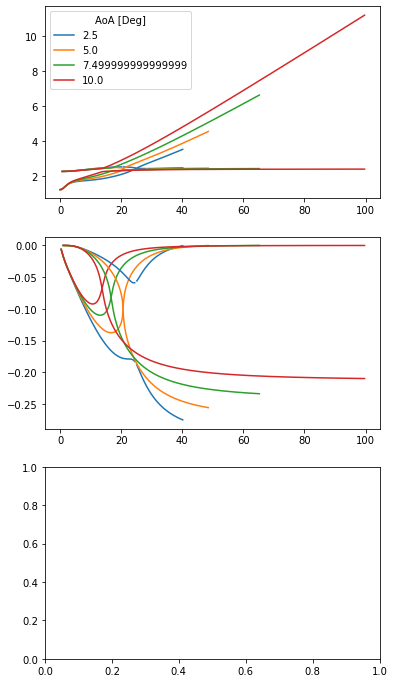

In [127]:
filter_dict = {'Flare Angle [Deg]':[10],'Mode':[0,1],'Stable':True}

data = cpo.GetReducedDataSet(flutdf,filter_dict)
fig, axes = plt.subplots(3,1,figsize=(6,12))  
cpo.FlutterPlot(data,x = 'V',style=None, Modes = 'Mode',hue = 'AoA [Deg]',y = 'Frequency',ax = axes[0],legend=True)
cpo.FlutterPlot(data,x = 'V',style=None, Modes = 'Mode',hue = 'AoA [Deg]',y = 'Damping',ax = axes[1],legend=False)

In [132]:
p.alpha_r.value = np.deg2rad(5)
p.V.value = 30
nm = mf.NumericModel.from_SymbolicModel(p,model_mini)
# Define Objective Function for solver
def objectiveDeriv(t,y):
    tup = p.GetNumericTuple(y,t)
    return nm.deriv(t,y,tup)
time = 10
# Generate I.C. and run the solver
x = [0]*4
x[0] = -0.05
yData = solve_ivp(objectiveDeriv,(0,time),x,max_step=0.01)

#interpolate to reduce t and y points
int_func = interp1d(yData.t,yData.y)

t = np.linspace(0,time,(time*100)+1)
yi = int_func(t)

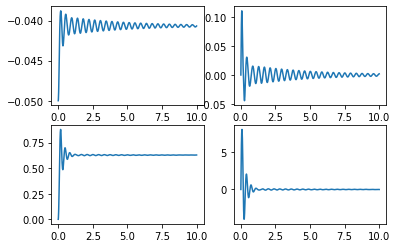

In [133]:
plt.subplot(2, 2, 1)
plt.plot(t,yi[0])
plt.subplot(2, 2, 2)
plt.plot(t,yi[1])
plt.subplot(2, 2, 3)
plt.plot(t,yi[2])
plt.subplot(2, 2, 4)
plt.plot(t,yi[3])